# Predict Avocado Price with Random Forest Regression

In [10]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## Load data & preprocessing

In [11]:
data = pd.read_csv('../data/avocado.csv')

In [12]:
data['Date'] = pd.to_datetime(data['Date'])

In [13]:
# convert type into 
dummy_type = pd.get_dummies(data['type'])
data = pd.concat([data, dummy_type], axis=1)
print(data.sample(2))

      Unnamed: 0       Date  AveragePrice  Total Volume       4046       4225  \
6514          50 2017-01-15          1.44     251547.43   47536.54  126095.12   
2899          39 2016-03-27          0.98     458635.34  286918.40   59289.93   

         4770  Total Bags  Small Bags  Large Bags  XLarge Bags          type  \
6514   791.62    77124.15    75330.56     1793.59         0.00  conventional   
2899  1320.02   111106.99    78824.96    32268.42        13.61  conventional   

      year              region  conventional  organic  
6514  2017  HarrisburgScranton             1        0  
2899  2016             Atlanta             1        0  


In [14]:
# convert region into categorical variables
data['region'] = data['region'].astype('category')
data['region'] = data['region'].cat.codes
data['region'].sample(3)

224       4
12677    14
3293      9
Name: region, dtype: int8

In [15]:
# re-scale Date into quarters
data['Date_Q'] = data['Date'].apply(lambda x: x.quarter)
data['Date_Q'].value_counts()

1    5508
4    4319
3    4212
2    4210
Name: Date_Q, dtype: int64

## Implement Random Forest Regression from scratch

In [16]:
class RandomForestRegression():
    """
    Implement Python version of Random Forest Regression model from scratch.
    """

    def __init__(self, n_estimators, min_leaf_sz=5, max_depth=None):
        self._n_estimators = n_estimators
        self._sample_sz = 0
        self._min_leaf_sz = min_leaf_sz
        self._max_depth = max_depth
        self._trees = [self._create_tree() for i in range(self._n_estimators)]
    
    def _get_sample_data(self, bootstrap=True):
        """
        Generate training data for each decision tree
        
        Parameters
        ----------
        bootstrap: boolean value, True/False
            The default value is True, it would bootstrap sample from 
            input training data. If False, the exclusive sampling will
            be performed.
            
        Returns
        -------
        idxs: array-like object
            Return the indices of sampled data from input training data
        """
        if bootstrap:
            idxs = np.random.choice(len(self._X), self._sample_sz)
        else:
            idxs = np.random.permutation(len(self._X))[:self._sample_sz]
        return idxs
    
    def _create_tree(self):
        """
        Buliding decision tree
        
        Returns
        -------
        tree: DTreeRegressor object
        """
        return DTreeRegressor(self._min_leaf_sz, self._max_depth)
    
    def _fit_single_tree(self, tree):
        """
        Fit single decision tree

        Parameters
        ----------
        tree : DTreeRegressor object
        
        Returns
        -------
        tree : DTreeRegressor object
        """
        sample_idxs = self._get_sample_data()
        return tree.fit(self._X.iloc[sample_idxs], self._y[sample_idxs])
    
    def fit(self, X, y):
        """
        Training a Random Forest Regression model

        Parameters
        ----------
        X : DataFrame,
            The training input samples.
            
        y : Series or array-like object
            The target values.
        """
        self._X = X
        self._y = y
        self._sample_sz = self._X.shape[0]
        for tree in self._trees:
            self._fit_single_tree(tree)
    
    def predict(self, X):
        """
        Predict data with trained model

        Parameters
        ---------
        X : DataFrame or array-like object
           input samples
           
        Returns
        -------
        preds : array-like object
            predicted target values
        """
        preds = np.stack([tree.predict(X) for tree in self._trees])
        return np.mean(preds, axis=0)
    
    @property
    def feature_importances_(self):
        """
        Calculate feature importance
        
        Returns
        -------
        self._feature_importances : array-like object
            the importance score of each feature 
        """
        if not hasattr(self, '_feature_importances'):
            norm_imp = np.zeros(len(self._X.columns))
            for tree in self._trees:
                t_imp = tree.calc_feature_importance()
                norm_imp = norm_imp + t_imp / np.sum(t_imp)
            self._feature_importances = norm_imp / self._n_estimators
        return self._feature_importances


class DTreeRegressor():
    """
    Create Decision Tree Regression object
    """

    def __init__(self, min_leaf_sz, max_depth=None):
        self._score = float('inf')
        self._split_point = 0
        self._split_col_idx = 0
        self._node_importance = 0
        self._feature_importances = []
        self._sample_sz = 0
        self._left_child_tree = None
        self._right_child_tree = None
        self._min_leaf_sz = min_leaf_sz
        if max_depth is not None:
            max_depth -= 1
        self._max_depth = max_depth

    def fit(self, X, y):
        """
        Training model
        """
        self._X = X
        self._y = y
        self._col_names = self._X.columns
        self._feature_importances = np.zeros(len(self._col_names))
        self._sample_sz = len(self._X)
        self._val = np.mean(self._y)
        if self._max_depth is not None and self._max_depth < 2: 
            return self
        self._find_best_split()
        return self
    
    def _find_best_split(self):
        for col_idx in range(len(self._col_names)):
            self._find_col_best_split_point(col_idx)
        
        self._feature_importances[self._split_col_idx] = self._node_importance
        if self.is_leaf:
            return
        
        lchild_sample_idxs = np.nonzero(self.split_col <= self.split_point)[0]
        rchild_sample_idxs = np.nonzero(self.split_col > self.split_point)[0]

        self._left_child_tree = (DTreeRegressor(self._min_leaf_sz, self._max_depth).fit(self._X.iloc[lchild_sample_idxs], self._y[lchild_sample_idxs]))
        self._right_child_tree = (DTreeRegressor(self._min_leaf_sz, self._max_depth).fit(self._X.iloc[rchild_sample_idxs], self._y[rchild_sample_idxs]))

    def _find_col_best_split_point(self, col_idx):
        # sort X and y by single column
        X_col = self._X.values[:, col_idx]
        sorted_idxs = np.argsort(X_col)
        X_sorted = X_col[sorted_idxs]
        y_sorted = self._y[sorted_idxs]
        
        lchild_n_samples = 0
        lchild_y_sum = 0.0
        lchild_y_square_sum = 0.0

        rchild_n_samples = self._sample_sz
        rchild_y_sum = y_sorted.sum()
        rchild_y_square_sum = (y_sorted ** 2).sum()

        node_y_sum = rchild_y_sum
        node_y_square_sum = rchild_y_square_sum

        for i in range(0, self._sample_sz - self._min_leaf_sz):
            xi, yi = X_sorted[i], y_sorted[i]
            rchild_n_samples -= 1
            rchild_y_sum -= yi
            rchild_y_square_sum -= yi ** 2
            lchild_n_samples += 1
            lchild_y_sum += yi
            lchild_y_square_sum += yi ** 2

            if i < self._min_leaf_sz or xi == X_sorted[i + 1]:
                continue

            lchild_impurity = self._calc_mse_impurity(lchild_y_square_sum, lchild_y_sum, lchild_n_samples)
            rchild_impurity = self._calc_mse_impurity(rchild_y_square_sum, rchild_y_sum, rchild_n_samples)
            split_score = (lchild_n_samples * lchild_impurity + rchild_n_samples * rchild_impurity) / self._sample_sz
            
            if split_score < self._score:
                self._score = split_score
                self._split_point = xi
                self._split_col_idx = col_idx
                self._node_importance = self._sample_sz * (self._calc_mse_impurity(node_y_square_sum, node_y_sum, self._sample_sz) - split_score)

    def _calc_mse_impurity(self, y_square_sum, y_sum, y_n):
        """
        Calculate Mean Squared Error impurity

        Parameters
        ----------
        y_squared_sum: float or int , the sum of y squared 
        y_sum: float or int , the sum of y value
        y_n: int, the number of samples

        Returns
        -------
        MSE value
        """
        return (y_square_sum / y_n) - (y_sum / y_n) ** 2  # todo: study this formula

    def predict(self, X):
        if type(X) == pd.DataFrame:
            X = X.values
        return np.array([self._predict_row(row) for row in X])
    
    def _predict_row(self, row):
        if self.is_leaf:
            return self._val
        t = (self._left_child_tree if row[self._split_col_idx] <= self.split_point else self._right_child_tree)
        return t._predict_row(row)
    
    def calc_feature_importance(self):
        if self.is_leaf:
            return self._feature_importances
        return (self._feature_importances 
                + self._left_child_tree.calc_feature_importance()
                + self._right_child_tree.calc_feature_importance()
               )

    @property
    def split_name(self):
        return self._col_names[self._split_col_idx]

    @property
    def split_col(self):
        return self._X.iloc[:, self._split_col_idx]
    
    @property
    def is_leaf(self):
        return self._score == float('inf')
    
    @property
    def split_point(self):
        return self._split_point


## Build models

In [17]:
X_columns = ['Total Volume', '4046', '4225', '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'conventional', 'organic', 
             'Date_Q', 'year', 'region']
X = data[X_columns]
y = data['AveragePrice']
X.shape, y.shape

((18249, 13), (18249,))

In [18]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14599, 13), (3650, 13), (14599,), (3650,))

## Training / predicting models

In [19]:
# Build random forest regression model
model = RandomForestRegression(n_estimators=128, max_depth=60)

In [20]:
%%time
model.fit(X_train, np.array(y_train))

Wall time: 8.05 s


In [21]:
y_pred = model.predict(X_test)

In [22]:
y_pred

array([1.65032748, 1.15400174, 1.15400174, ..., 1.15400174, 1.15400174,
       1.65032748])

## Evaluation

In [95]:
model.feature_importances_

array([0.0325676 , 0.09225299, 0.07948729, 0.03739179, 0.0383171 ,
       0.04052469, 0.09294673, 0.0087996 , 0.09054837, 0.30988103,
       0.05942869, 0.07019839, 0.04765573])

In [102]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
print('MASE for test set: {}'.format(np.mean(np.abs(y_pred - y_test) / np.abs(y_test))))
print('RMSE for test set: {}'.format(np.sqrt(mean_squared_error(y_pred, y_test))))

MASE for test set: 0.07562438192714921
RMSE for test set: 0.14732812736126935


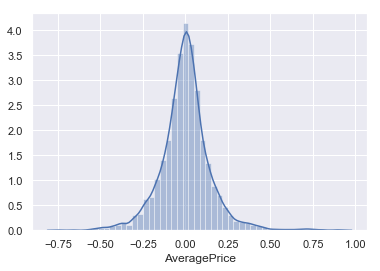

In [106]:
sns.set(font_scale=1)
sns.distplot((y_test-y_pred),bins=50)

In [85]:
importances = model.feature_importances_

In [86]:
weights = pd.Series(importances,
                 index=X.columns.values)

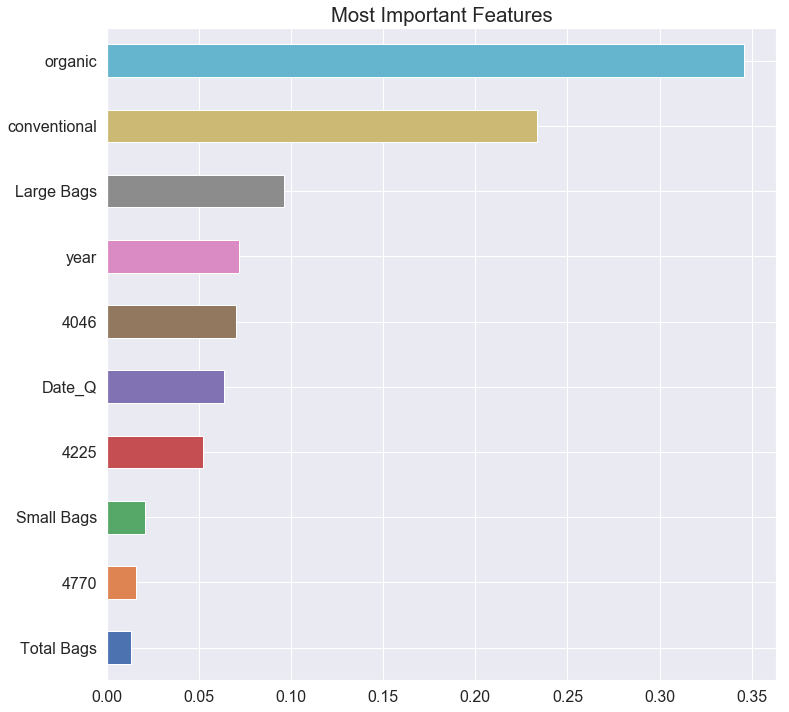

In [97]:
plt.figure(figsize=(12, 12))
weights.sort_values()[-10:].plot(kind = 'barh', title='Most Important Features', fontsize=16)